In [ ]:
%reset -f
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config Completer.use_jedi = False

In [ ]:
import sys
sys.path.insert(0,"..")
import torch
# torch.manual_seed(42)
import torch.nn as nn
import torch.optim as optim
import torchaudio
from torch.utils.data import Dataset, ConcatDataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms
import libmr
from openmax import compute_train_score_and_mavs_and_dists,fit_weibull,openmax,compute_channel_distances
from sklearn.metrics import balanced_accuracy_score
from tqdm import tqdm
# from tqdm.notebook import tqdm as tqdm
import numpy as np
import pandas as pd

import copy
from losses import *
import time
torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE = False
torchaudio.set_audio_backend('soundfile')
import os
import random
from pathlib import Path

import matplotlib.pyplot as plt
import psutil
import requests

from utils import *
from datasets import *
from models import *

losschoice = 'ce'
num_classes = 2
num_epochs = 30
batch_size = 32
batch_size_val = batch_size * 2
validation_split = .2
shuffle_dataset = True
num_workers = psutil.cpu_count()
random_seed= 42
setting = 'raw'
modeltype = 'wingbeatraw'
normalize = ""#"sample"

In [ ]:
transforms_list = [FilterWingbeat(setting='bandpass')]

if normalize == "whole":
    dmel1 = WingbeatsDataset(dsname="Melanogaster_RL/Y", clean=True,transform=transforms.Compose(transforms_list))
    dsuz1 = WingbeatsDataset(dsname="Suzukii_RL/L", clean=True, transform=transforms.Compose(transforms_list))
    transformed_dataset = ConcatDataset([dmel1, dsuz1])
    trainval_dataloader = DataLoader(transformed_dataset, batch_size=batch_size, num_workers=num_workers)

    mean, std = calc_mean_std_1D(loader=trainval_dataloader)
    transforms_list += [Normalize(mean=mean, std=std, axes=(0,2))]
elif normalize == "sample":
    transforms_list += [Normalize()]
else:
    pass

dmel1 = WingbeatsDataset(dsname="Melanogaster_RL/Z", custom_label=[0], clean=True, transform=transforms.Compose(transforms_list))
dmel2 = WingbeatsDataset(dsname="Melanogaster_RL/Y", custom_label=[0], clean=True, transform=transforms.Compose(transforms_list))
dsuz1 = WingbeatsDataset(dsname="Suzukii_RL/Y",      custom_label=[1], clean=True, transform=transforms.Compose(transforms_list))
dsuz2 = WingbeatsDataset(dsname="Suzukii_RL/X",      custom_label=[1], clean=True, transform=transforms.Compose(transforms_list))

trainsets = [dmel1, dsuz1]
testsets = [dmel2, dsuz2]

transformed_dataset = ConcatDataset(trainsets)
trainval_dataloader = DataLoader(transformed_dataset, batch_size=batch_size, num_workers=num_workers)
train_size = int(0.8 * len(transformed_dataset))
valid_size = len(transformed_dataset) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(transformed_dataset, [train_size, valid_size])
test_dataset = ConcatDataset(testsets)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size_val, num_workers=num_workers, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size_val, num_workers=num_workers, shuffle=True)

In [ ]:
from IPython.display import Audio
sig = train_dataset[6][0]
plt.plot(sig.T); plt.ylim(-.04,.04)
Audio(sig, rate=8000, autoplay=True)

In [7]:
if setting.startswith('psd'):
    model = Conv1dNetPSD()
elif modeltype == 'wingbeatraw':
    model = Conv1dNetRAW()
elif modeltype == 'inception':
    model = nn.Sequential(
                    InceptionBlock(
                        in_channels=1, 
                        n_filters=32, 
                        kernel_sizes=[5, 11, 23],
                        bottleneck_channels=32,
                        use_residual=True,
                        activation=nn.ReLU()
                    ),
                    InceptionBlock(
                        in_channels=32*4, 
                        n_filters=32, 
                        kernel_sizes=[5, 11, 23],
                        bottleneck_channels=32,
                        use_residual=True,
                        activation=nn.ReLU()
                    ),
                    nn.AdaptiveAvgPool1d(output_size=1),
                    Flatten(out_features=32*4*1),
                    nn.Linear(in_features=4*32*1, out_features=2))


In [8]:
if losschoice == 'digamma':
    criterion = edl_digamma_loss
elif losschoice == 'log':
    criterion = edl_log_loss
elif losschoice == 'mse':
    criterion = edl_mse_loss
else:
    criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.999))
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)
early_stopping = EarlyStopping(patience=7, verbose=1)

In [9]:
# train_class_num = 2
# weibull_tail = 20 #20
# weibull_alpha = 2
# weibull_threshold = 0.001

## Training

In [11]:
y_train = [train_dataloader.dataset[i][1] for i in range(len(train_dataloader.dataset))]

In [ ]:
v

In [ ]:
from sklearn.utils import class_weight
weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i : weights[i] for i in range(num_classes)}

class_weights = torch.tensor(list(class_weights.values())).cuda()
criterion = nn.CrossEntropyLoss(weight=class_weights.float())
print(class_weights)

In [22]:
# Choosing whether to train on a gpu
train_on_gpu = torch.cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')# Number of gpus
device = 'cuda'
model = model.to(device, dtype=torch.float)

# Model training
for epoch in range(num_epochs):
    # Going through the training set
    correct_train = 0
    model.train()
    for x_batch,y_batch,path_batch,idx_batch in tqdm(train_dataloader, desc=f'Epoch: {epoch}\tTraining..'):        

        y_batch = torch.as_tensor(y_batch).type(torch.LongTensor)
        x_batch,y_batch = x_batch.cuda(), y_batch.cuda()
        
        optimizer.zero_grad()
        pred = model(x_batch)
        loss = criterion(pred, y_batch)
        loss.backward()
        optimizer.step()
        correct_train += (pred.argmax(axis=1) == y_batch).float().sum().item()

    train_accuracy = correct_train / (len(train_dataloader)*batch_size) * 100.
    # Going through the validation set
    #if epoch != 0: #and epoch % 5 == 0:
    correct_valid = 0
    model.eval()
    scores, labels = [],[]
    with torch.no_grad():
        for x_batch,y_batch,path_batch,idx_batch in tqdm(valid_dataloader, desc='Validating..\t'):

            y_batch = torch.as_tensor(y_batch).type(torch.LongTensor)
            x_batch,y_batch = x_batch.cuda(), y_batch.cuda()

            pred = model(x_batch)

            scores.append(pred)
            labels.append(y_batch)

            val_loss = criterion(pred, y_batch)
            correct_valid += (pred.argmax(axis=1) == y_batch).float().sum().item()
        valid_accuracy = correct_valid / (len(valid_dataloader)*batch_size_val) * 100.
        scheduler.step(val_loss)
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break

        scores = torch.cat(scores,dim=0).cpu().numpy()
        labels = torch.cat(labels,dim=0).cpu().numpy()
        scores = np.array(scores)[:, np.newaxis, :]
        labels = np.array(labels)

#         # Fit the weibull distribution from training data.
#         print("Fittting Weibull distribution...")
#         try:    
#             _, mavs, dists = compute_train_score_and_mavs_and_dists(train_class_num, valid_dataloader, device, model)
#             categories = list(range(0, train_class_num))
#             weibull_model = fit_weibull(mavs, dists, categories, weibull_tail, "cosine")
#         except:
#             print("Failed to fit Weibull distribution..")
#             continue

#     pred_softmax, pred_softmax_threshold, pred_openmax = [], [], []
#     score_softmax, score_openmax = [], []
#     for score in scores:
#         so, ss = openmax(weibull_model, categories, score, 0.5, weibull_alpha, "cosine")  # openmax_prob, softmax_prob
#         pred_softmax.append(np.argmax(ss))
#         pred_softmax_threshold.append(np.argmax(ss) if np.max(ss) >= weibull_threshold else train_class_num)
#         pred_openmax.append(np.argmax(so) if np.max(so) >= weibull_threshold else train_class_num)
#         score_softmax.append(ss)
#         score_openmax.append(so)

#     print("Evaluation...")
#     print(f"Softmax: {balanced_accuracy_score(y_true=labels, y_pred=pred_softmax)}")
#     print(f"Thr_Softmax: {balanced_accuracy_score(y_true=labels, y_pred=pred_softmax_threshold)}")
#     print(f"Openmax: {balanced_accuracy_score(y_true=labels, y_pred=pred_openmax)}")

    # Printing results
    print(f"Epoch {epoch}: train_acc: {train_accuracy:.2f}% loss: {loss:.3f},  val_loss: {val_loss:.3f} val_acc: {valid_accuracy:.2f}%")


Epoch: 0	Training..:   0%|          | 0/758 [00:00<?, ?it/s]

Train on gpu: True


Epoch: 1	Training..:   0%|          | 0/758 [00:00<?, ?it/s]

Validation loss decreased (inf --> 6.962286).  Saving model ...
Epoch 0: train_acc: 89.43% loss: 0.199,  val_loss: 6.962 val_acc: 40.36%


Epoch: 2	Training..:   0%|          | 0/758 [00:00<?, ?it/s]

Validation loss decreased (6.962286 --> 2.330670).  Saving model ...
Epoch 1: train_acc: 93.26% loss: 0.070,  val_loss: 2.331 val_acc: 60.26%


Epoch: 3	Training..:   0%|          | 0/758 [00:00<?, ?it/s]

Validation loss decreased (2.330670 --> 0.544374).  Saving model ...
Epoch 2: train_acc: 94.04% loss: 0.088,  val_loss: 0.544 val_acc: 58.09%


Epoch: 4	Training..:   0%|          | 0/758 [00:00<?, ?it/s]

Epoch 3: train_acc: 94.67% loss: 0.053,  val_loss: 0.572 val_acc: 72.78%


Epoch: 5	Training..:   0%|          | 0/758 [00:00<?, ?it/s]

Epoch 4: train_acc: 95.14% loss: 0.128,  val_loss: 2.662 val_acc: 54.37%


Epoch: 6	Training..:   0%|          | 0/758 [00:00<?, ?it/s]

Epoch 5: train_acc: 95.48% loss: 0.397,  val_loss: 2.467 val_acc: 59.52%


Epoch: 7	Training..:   0%|          | 0/758 [00:00<?, ?it/s]

Epoch     7: reducing learning rate of group 0 to 1.0000e-03.
Epoch 6: train_acc: 95.97% loss: 0.040,  val_loss: 8.477 val_acc: 47.60%


Epoch: 8	Training..:   0%|          | 0/758 [00:00<?, ?it/s]

Validation loss decreased (0.544374 --> 0.162518).  Saving model ...
Epoch 7: train_acc: 97.38% loss: 0.167,  val_loss: 0.163 val_acc: 96.68%


Epoch: 9	Training..:   0%|          | 0/758 [00:00<?, ?it/s]

Validation loss decreased (0.162518 --> 0.079859).  Saving model ...
Epoch 8: train_acc: 97.78% loss: 0.011,  val_loss: 0.080 val_acc: 93.82%


Epoch: 10	Training..:   0%|          | 0/758 [00:00<?, ?it/s]

Epoch 9: train_acc: 98.05% loss: 0.006,  val_loss: 1.038 val_acc: 81.48%


Epoch: 11	Training..:   0%|          | 0/758 [00:00<?, ?it/s]

Epoch 10: train_acc: 98.14% loss: 0.060,  val_loss: 0.152 val_acc: 93.26%


Epoch: 12	Training..:   0%|          | 0/758 [00:00<?, ?it/s]

Epoch 11: train_acc: 98.17% loss: 0.016,  val_loss: 0.546 val_acc: 84.70%


Epoch: 13	Training..:   0%|          | 0/758 [00:00<?, ?it/s]

Epoch    13: reducing learning rate of group 0 to 1.0000e-04.
Epoch 12: train_acc: 98.26% loss: 0.005,  val_loss: 1.682 val_acc: 83.98%


Epoch: 14	Training..:   0%|          | 0/758 [00:00<?, ?it/s]

Epoch 13: train_acc: 98.63% loss: 0.008,  val_loss: 0.115 val_acc: 96.78%


Epoch: 15	Training..:   0%|          | 0/758 [00:00<?, ?it/s]

Validation loss decreased (0.079859 --> 0.023685).  Saving model ...
Epoch 14: train_acc: 98.54% loss: 0.005,  val_loss: 0.024 val_acc: 97.37%


Epoch: 16	Training..:   0%|          | 0/758 [00:00<?, ?it/s]

Validation loss decreased (0.023685 --> 0.008995).  Saving model ...
Epoch 15: train_acc: 98.71% loss: 0.027,  val_loss: 0.009 val_acc: 97.45%


Epoch: 17	Training..:   0%|          | 0/758 [00:00<?, ?it/s]

Epoch 16: train_acc: 98.68% loss: 0.004,  val_loss: 0.046 val_acc: 97.50%


Epoch: 18	Training..:   0%|          | 0/758 [00:00<?, ?it/s]

Epoch 17: train_acc: 98.76% loss: 0.035,  val_loss: 0.156 val_acc: 97.07%


Epoch: 19	Training..:   0%|          | 0/758 [00:00<?, ?it/s]

Epoch 18: train_acc: 98.71% loss: 0.024,  val_loss: 0.021 val_acc: 95.90%


Epoch: 20	Training..:   0%|          | 0/758 [00:00<?, ?it/s]

Epoch    20: reducing learning rate of group 0 to 1.0000e-05.
Epoch 19: train_acc: 98.66% loss: 0.004,  val_loss: 0.031 val_acc: 96.99%


Epoch: 21	Training..:   0%|          | 0/758 [00:00<?, ?it/s]

Epoch 20: train_acc: 98.68% loss: 0.043,  val_loss: 0.136 val_acc: 97.24%


Epoch: 22	Training..:   0%|          | 0/758 [00:00<?, ?it/s]

Epoch 21: train_acc: 98.80% loss: 0.039,  val_loss: 0.099 val_acc: 97.47%


Validating..	: 100%|██████████| 95/95 [00:01<00:00, 71.09it/s] 

Early stopping


## Testing

### testing on datasets with same conditions

In [66]:
model = Conv1dNetRAW()

checkpoint = torch.load('../data_created/checkpoint.pt')
model.load_state_dict(checkpoint)

# Choosing whether to train on a gpu
train_on_gpu = torch.cuda.is_available()
device = 'cuda'
print(f'Train on gpu: {train_on_gpu}')# Number of gpus
model = model.to(device, dtype=torch.float)

Train on gpu: True


In [67]:
dpip = WingbeatsDataset(dsname="Wingbeats/C. pipiens", custom_label=[2], clean=True, transform=transforms.Compose(transforms_list))
test_dataset = ConcatDataset([dmel2, dsuz2, dpip])#([])#, dpip])
test_dataloader = DataLoader(test_dataset, batch_size=batch_size_val, num_workers=num_workers, shuffle=True)

Found 29475 in dataset: Wingbeats/C. pipiens, and 1 label(s): ['C. pipiens']
Label(s) changed to [2]


In [68]:
# model = model.to('cpu', dtype=torch.float)
model.eval()
scores, labels = [],[]
with torch.no_grad():
    for x_batch,y_batch,path_batch,idx_batch in tqdm(test_dataloader, desc='testing..\t'):
        y_batch = torch.as_tensor(y_batch).type(torch.LongTensor)
        x_batch,y_batch = x_batch.cuda(), y_batch.cuda()
        pred = model(x_batch)
        scores.append(pred)
        labels.append(y_batch)
    scores = torch.cat(scores,dim=0).cpu().numpy()
    labels = torch.cat(labels,dim=0).cpu().numpy()
    scores = np.array(scores)[:, np.newaxis, :]
    labels = np.array(labels)
    

testing..	: 100%|██████████| 878/878 [00:05<00:00, 158.12it/s]


In [69]:
train_class_num = 2
weibull_tail = 160 #20
weibull_alpha = 2
weibull_threshold = 0.9

In [70]:
try:    
    _, mavs, dists = compute_train_score_and_mavs_and_dists(train_class_num, test_dataloader, device, model)
    categories = list(range(0, train_class_num))
    weibull_model = fit_weibull(mavs, dists, categories, weibull_tail, "cosine")
except:
    print("Failed to fit Weibull distribution..")

Evaluation...
Softmax: 0.6042329280292998
Thr_Softmax: 0.5589694110312631
Openmax: 0.46426859229060574


1    37949
2    11572
0     6660
dtype: int64

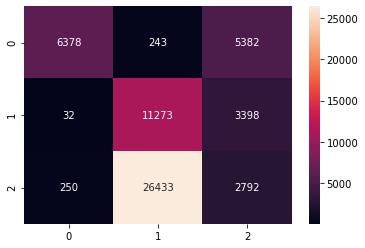

In [71]:
pred_softmax, pred_softmax_threshold, pred_openmax = [], [], []
score_softmax, score_openmax = [], []
for score in scores:
    so, ss = openmax(weibull_model=weibull_model, 
                     categories=categories, 
                     input_score=score, 
                     eu_weight=0.5, 
                     alpha=weibull_alpha, 
                     distance_type="cosine") 
    pred_softmax.append(np.argmax(ss))
    pred_softmax_threshold.append(np.argmax(ss) if np.max(ss) >= weibull_threshold else train_class_num)
    pred_openmax.append(np.argmax(so) if np.max(so) >= weibull_threshold else train_class_num)
    score_softmax.append(ss)
    score_openmax.append(so)
    
print("Evaluation...")
print(f"Softmax: {balanced_accuracy_score(y_true=labels, y_pred=pred_softmax)}")
print(f"Thr_Softmax: {balanced_accuracy_score(y_true=labels, y_pred=pred_softmax_threshold)}")
print(f"Openmax: {balanced_accuracy_score(y_true=labels, y_pred=pred_openmax)}")    

import seaborn as sns
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_true=labels, y_pred=pred_openmax), annot=True, fmt='g')
pd.Series(pred_openmax).value_counts()

In [73]:
model_xtractor = SlicedModel(model)

In [123]:
model_xtractor.eval()
features = []
with torch.no_grad():
    for x_batch,y_batch,path_batch,idx_batch in tqdm(test_dataloader, desc='testing..\t'):
        y_batch = torch.as_tensor(y_batch).type(torch.LongTensor)
        x_batch,y_batch = x_batch.cuda(), y_batch.cuda()
        features.extend([model_xtractor(x_batch).cpu()])
features = np.vstack(features).squeeze()

testing..	: 100%|██████████| 878/878 [00:06<00:00, 138.39it/s]


In [125]:
y_test = [test_dataloader.dataset[i][1] for i in range(len(test_dataloader.dataset))]

In [128]:
plt.figure(figsize=(20,14));
import umap
import umap.plot

mapper = umap.UMAP(random_state=seed).fit(features)

[autoreload of decorator failed: Traceback (most recent call last):
  File "/home/kalfasyan/anaconda3/envs/wbai/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/kalfasyan/anaconda3/envs/wbai/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/home/kalfasyan/anaconda3/envs/wbai/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/home/kalfasyan/anaconda3/envs/wbai/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 266, in update_function
    setattr(old, name, getattr(new, name))
ValueError: contextmanager() requires a code object with 0 free vars, not 3
]
[autoreload of pygments.lexer failed: Traceback (most recent call last):
  File "/home/kalfasyan/anaconda3/envs/wbai/lib/python3.6/site-packages/IPython/extensions/autoreload.py", lin

TypeError: 'transform' must be an instance of matplotlib.transforms.Transform, not a matplotlib.transforms.Affine2D

In [129]:
umap.plot.points(mapper, labels=np.array(y_test), theme='darkred');

NameError: name 'umap' is not defined